In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from 'D:\\3term\\DANA 4830\\study_4830\\utils.py'>

In [3]:
df = pd.read_csv('data.csv').drop(columns = 'ID', axis=1)
df = df.dropna(axis=0, how='any')
X = df.drop(columns = 'class', axis =1 )
y = df['class']
df.head()

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,0.051836,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,0.039827,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,0.064220,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,0.090408,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,0.037528,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


In [4]:
int_columns, float_columns, object_columns, numerical_columns = utils.columns_df(X)

Shape: (174, 450)
Numerical features:  450
Categorical features:  0


In [5]:
X_v = pd.DataFrame()

In [6]:
for r in range(X.shape[0]):
    row = X.iloc[r,:]
    features = {}
    for i in range(25):
        task = 'task_' + str(i+1)
        i_vector = []
        lim_inf = i*18
        lim_sup = i*18+17
        features[task] = np.array(row[lim_inf:lim_sup+1])
    row_df = pd.DataFrame([features])
    X_v = pd.concat([X_v, row_df], ignore_index=True)

# PCA

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
X_pca_dict = {}
columns_pca_dict = {}
for i in range(25):
    mytask = 'task_' + str(i+1)
    task_i = X_v[mytask]
    task_i_df = pd.DataFrame(task_i.tolist(), index = task_i.index)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(task_i_df)
    
    pca = PCA(0.8)
    X_pca = pca.fit_transform(X_scaled)
    n_columns_pca = X_pca.shape[1]
    
    columns_pca = [mytask+'_PC_'+str(i+1) for i in range(n_columns_pca)]
    columns_pca_dict[mytask] = columns_pca
    
    X_pca_df = pd.DataFrame(X_pca)
    X_pca_df.columns = columns_pca
    X_pca_dict[mytask] = X_pca_df

In [8]:
df_of_pca = pd.DataFrame()
for k, v in X_pca_dict.items():
    df_of_pca = pd.concat([df_of_pca, X_pca_dict[k]], axis=1)

In [9]:
print('Original shape: ', X.shape)
print('New shape, after PCA: ',df_of_pca.shape)

Original shape:  (174, 450)
New shape, after PCA:  (174, 125)


# Train and test dataset split

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(139, 450) (139,)
(35, 450) (35,)


In [11]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_of_pca, y, test_size=0.2, random_state=123)
print(X_train2.shape, y_train2.shape)
print(X_test2.shape, y_test2.shape)

(139, 125) (139,)
(35, 125) (35,)


# 1. Full Dataset

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [13]:
accuracy_full = []
for f in range(100):
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test) 
    accuracy_full.append(accuracy_score(y_test, y_pred))

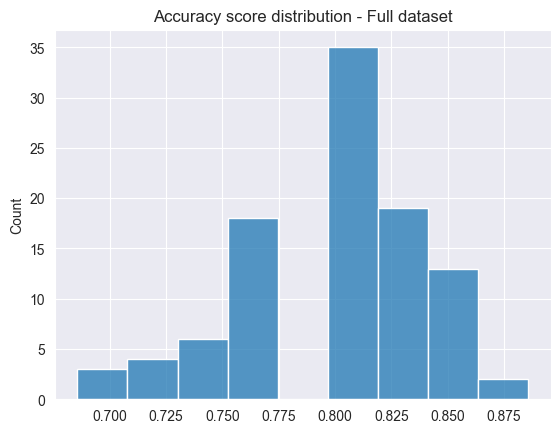

In [14]:
sns.histplot(accuracy_full)
plt.title('Accuracy score distribution - Full dataset')
plt.show()

In [15]:
print('Mean: ', round(np.mean(accuracy_full),2))
print('Sd: ', round(np.std(accuracy_full),2))

Mean:  0.8
Sd:  0.04


# 2. PCA dataset

In [16]:
accuracy_pca = []
for f in range(100):
    clf2 = DecisionTreeClassifier()
    clf2.fit(X_train2, y_train2) 
    y_pred2 = clf2.predict(X_test2)
    accuracy_pca.append(accuracy_score(y_test2, y_pred2))

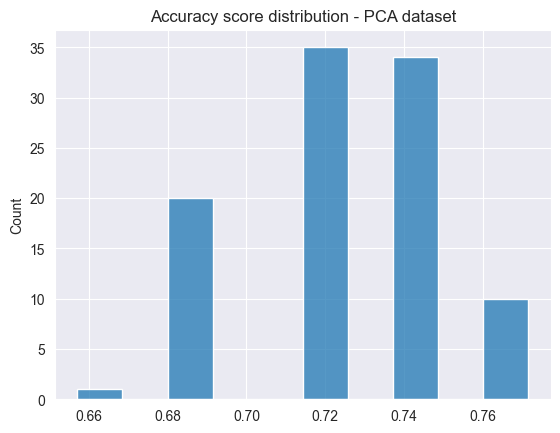

In [17]:
sns.histplot(accuracy_pca)
plt.title('Accuracy score distribution - PCA dataset')
plt.show()

In [18]:
print('Mean: ', round(np.mean(accuracy_pca),2))
print('Sd: ', round(np.std(accuracy_pca),2))

Mean:  0.72
Sd:  0.03


# Combined Decision Trees

In [19]:
accuracy_combined = []
for f in range(100):
    predict_dict = {}
    for t, columns in columns_pca_dict.items():
        X_train2_i = X_train2[columns]
        X_test2_i = X_test2[columns]
    
        clf_i = DecisionTreeClassifier()
        clf_i.fit(X_train2_i, y_train2)
        y_pred_i = clf_i.predict(X_test2_i)
        
        predict_dict[t] = y_pred_i
        
    predict_tuple = tuple([i for i in predict_dict.values()])
    pred_accumulate = np.vstack(predict_tuple).T
    
    y_pred_combined = np.apply_along_axis(utils.most_frequent, 1, pred_accumulate)
    
    accuracy_combined.append(accuracy_score(y_test, y_pred_combined))

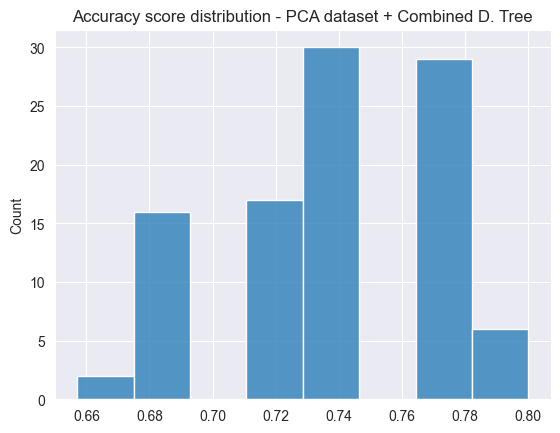

In [20]:
sns.histplot(accuracy_combined)
plt.title('Accuracy score distribution - PCA dataset + Combined D. Tree')
plt.show()

In [21]:
print('Mean: ', round(np.mean(accuracy_combined),2))
print('Sd: ', round(np.std(accuracy_combined),2))

Mean:  0.74
Sd:  0.03


# Comparing three approaches (Full dataset, PCA dataset, and Combined Decision Trees)

In [22]:
df_result = pd.DataFrame(
{'Dataset': ['Full dataset', 'PCA dataset','PCA dataset'  ]
,'Model': ['1 D. Tree m.', '1 D. Tree m. (PCA)', '25 Combined D. Trees (PCA)']
,'Accuracy score':
        [np.mean(accuracy_full)
         ,np.mean(accuracy_pca)
         ,np.mean(accuracy_combined)
        ]
     })
df_result

,Dataset,Model,Accuracy score
0,Full dataset,1 D. Tree m.,0.799143
1,PCA dataset,1 D. Tree m. (PCA),0.723429
2,PCA dataset,25 Combined D. Trees (PCA),0.738857


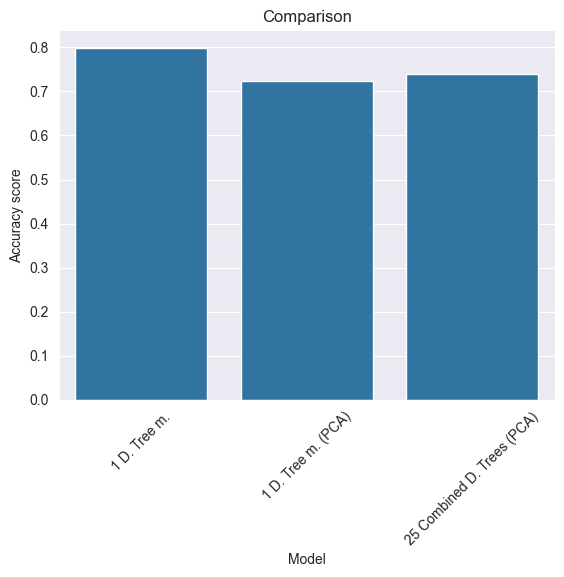

In [23]:
sns.barplot(x= 'Model',y= 'Accuracy score' , data=df_result)
plt.title('Comparison')
plt.xticks(rotation=45)
plt.show()